let's import some packages and define a few functions that will be helpful later


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import scipy
import scipy.io
import time
import sklearn.preprocessing

from collections import Counter

import os.path
from os import path

In [25]:
from matplotlib import pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## filter/log_normalize/convert the sparse matrix to a sparse tensor 
def make_log_maxn_tensor(sparseMatrix,ds_list,ds_type):
  # filter the sparse matrix... (note: cannot be a COO formatted matrix)
  indx = np.equal( np.array(ds_list,dtype=object),np.array(ds_type,dtype=object) )
  x0 = sparseMatrix[indx,:]
  del indx

  # get the log transform...
  x0.data = np.log1p(x0.data)
  # normalize to the max...
  sklearn.preprocessing.normalize(x0, norm="max", axis=1, copy=False)

  # convert the filtered matrix to COO format
  x0 = x0.tocoo()
  indices = np.mat([x0.row, x0.col]).transpose()

  # make a sparse tensor and re-order it...
  x0 = tf.SparseTensor(indices,x0.data,x0.shape)
  x0 = tf.sparse.reorder(x0)
  return x0


def make_cm(nn_model,test_data_x,test_data_y,labels):
    pred = nn_model.predict(test_data_x)
    cm = tf.math.confusion_matrix(
        labels=np.argmax(test_data_y,axis=1), predictions=np.argmax(pred,axis=1)
    )
    return cm
def make_pred_and_save_cm(nn_model,test_data_x,test_data_y,labels,output_path):
  pred = nn_model.predict(test_data_x)
  cm = tf.math.confusion_matrix(
    labels=np.argmax(test_data_y,axis=1), predictions=np.argmax(pred,axis=1)
  )
  np.savetxt(output_path, cm, delimiter=',', header=",".join(labels))
  print(np.diag(cm)/np.sum(cm,axis=1))

# Loading the data
The data is in the form of a sparse matrix (Matrix Market format) + labels(csv)

In [3]:
t0 = time.time()
genes = pd.read_csv("filtered_neurons_doublets_genes.tsv",names=["gene"])
df = pd.read_csv("filtered_neurons_doublets_barcodes.tsv",names=["cell_id"])
lbl = pd.read_csv("filtered_neurons_doublets_labels.csv")
t1 = time.time()
print(f"time to read data files: {t1-t0:.3f} s")
print(f"all cell_ids from the labels == cell_ids from matrix: {all(df.cell_id == lbl.cell_id)}")

t0 = time.time()
dirty_neurons = scipy.io.mmread("filtered_neurons_doublets.mtx")
t1 = time.time()
print(f"time to read matrix: {t1-t0:.3f} s")
if scipy.sparse.isspmatrix_coo(dirty_neurons):
  print("converting raw counts to CSR")
  t0 = time.time()
  dirty_neurons = dirty_neurons.tocsr()
  t1 = time.time()
  print(f"time to convert matrix: {t1-t0:.3f} s")

time to read data files: 0.073 s
all cell_ids from the labels == cell_ids from matrix: True
time to read matrix: 62.649 s
converting raw counts to CSR
time to convert matrix: -0.000 s


In [5]:
cell_label = lbl.final_cluster_assignment.values
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(set(cell_label)))
ohe_encoder = sklearn.preprocessing.LabelBinarizer()
ohe_encoder.fit(list(set(cell_label)))
num_classes = len(label_encoder.classes_)
y = ohe_encoder.transform(cell_label)
print(dict(Counter(cell_label)))
print(num_classes)
del cell_label

# save the label_encoder
np.save('dirty_neuron_encoder.npy', label_encoder.classes_)
# to load the encoder
# label_encoder = sklearn.preprocessing.LabelEncoder()
# label_encoder.classes_ = np.load('dirty_neuron_encoder.npy')
# ohe_encoder = sklearn.preprocessing.LabelBinarizer()
# ohe_encoder.classes_ = np.load('dirty_neuron_encoder.npy')

{'Garbage': 8885, 'Inhib-16': 311, 'Inhib-27': 619, 'Excit-23': 235, 'Excit-16': 721, 'Inhib-01': 908, 'Inhib-02': 727, 'Excit-12': 179, 'Excit-04': 394, 'Inhib-22': 250, 'Inhib-05': 150, 'Excit-36': 192, 'Excit-14': 421, 'Inhib-23': 512, 'Excit-01': 266, 'Excit-19': 455, 'Inhib-10': 221, 'Excit-05': 585, 'Inhib-17': 317, 'Excit-06': 390, 'Inhib-13': 240, 'Inhib-07': 353, 'Excit-31': 719, 'Excit-38': 92, 'Excit-10': 624, 'Excit-25': 202, 'Excit-24': 216, 'Inhib-15': 332, 'Excit-03': 323, 'Excit-18': 442, 'Excit-20': 491, 'Excit-27': 89, 'Inhib-12': 342, 'Inhib-06': 283, 'Inhib-08': 153, 'Excit-29': 154, 'Inhib-18': 164, 'Excit-13': 174, 'Inhib-04': 182, 'MN-alpha': 237, 'Excit-15': 274, 'Excit-08': 296, 'Inhib-11': 584, 'Excit-28': 27, 'Inhib-09': 283, 'Excit-32': 602, 'Excit-09': 279, 'Inhib-14': 135, 'MN-gamma': 88, 'Inhib-19': 139, 'Excit-21': 150, 'Excit-11': 166, 'Inhib-24': 139, 'CSF-cN': 126, 'Inhib-21': 65, 'Excit-22': 117, 'Excit-02': 117, 'Inhib-26': 34, 'Inhib-03': 215, 'Exc

# Split the data into Train, Validation, and Test data
using the md5 hash to make the split reproducible.  

In [8]:
import hashlib
bchash = list( map(lambda bc: int(hashlib.md5(bc.encode()).hexdigest(),16)%100,lbl.cell_id))
dataset = list( map(lambda hash: "Train" if hash<80 else ("Val" if hash < 90 else "Test"),bchash) )
del bchash
print(Counter(dataset))

Counter({'Train': 22591, 'Val': 2837, 'Test': 2810})


In [9]:
print(dirty_neurons.shape)
print(lbl.shape)
print(df.shape)
print(genes.shape)
print(len(dataset))

(28238, 25419)
(28238, 3)
(28238, 1)
(25419, 1)
28238


In [10]:
t0 = time.time()
x_train = make_log_maxn_tensor(dirty_neurons,dataset,"Train")
t1 = time.time()
print(f"time to convert sparse matrix to sparse tensor for the Training data: {t1-t0:.3f} s")
t0 = time.time()
x_val   = make_log_maxn_tensor(dirty_neurons,dataset,"Val")
t1 = time.time()
print(f"time to convert sparse matrix to sparse tensor for the Validation data: {t1-t0:.3f} s")
t0 = time.time()
x_test  = make_log_maxn_tensor(dirty_neurons,dataset,"Test")
t1 = time.time()
print(f"time to convert sparse matrix to sparse tensor for the Test data: {t1-t0:.3f} s")


time to convert sparse matrix to sparse tensor for the Training data: 2.855 s
time to convert sparse matrix to sparse tensor for the Validation data: 0.291 s
time to convert sparse matrix to sparse tensor for the Test data: 0.301 s


In [11]:
train_mask = [x == "Train" for x in dataset]
y_train    = y[train_mask,:]
val_mask   = [x == "Val" for x in dataset]
y_val      = y[val_mask,:]
test_mask  = [x == "Test" for x in dataset]
y_test    = y[test_mask,:]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(22591, 70)
(2837, 70)
(2810, 70)


# Make the network

In [12]:
num_inp = dirty_neurons.shape[1]
num_out = len(ohe_encoder.classes_)

print(f"in: {num_inp} out:{num_out}")

in: 25419 out:70


First a linear model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cell_type (Dense)            (None, 70)                1779400   
Total params: 1,779,400
Trainable params: 1,779,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
706/706 [==============================] - 7s 9ms/step - loss: 2.0510 - accuracy: 0.5560 - val_loss: 1.2671 - val_accuracy: 0.7237
Epoch 2/40
706/706 [==============================] - 7s 10ms/step - loss: 0.6871 - accuracy: 0.8699 - val_loss: 0.9308 - val_accuracy: 0.7737
Epoch 3/40
706/706 [==============================] - 7s 10ms/step - loss: 0.3661 - accuracy: 0.9420 - val_loss: 0.8393 - val_accuracy: 0.7730
Epoch 4/40
706/706 [==============================] - 7s 10ms/step - loss: 0.2193 - accuracy: 0.9737 - val_loss: 0.7665 - val_accuracy: 0.7959
Epoch 5/40
706/706 [==============================] - 7s 10ms/step 

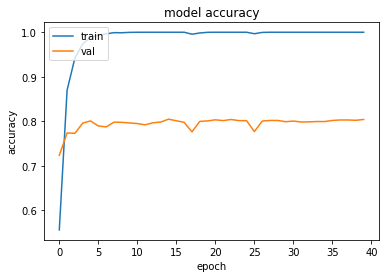

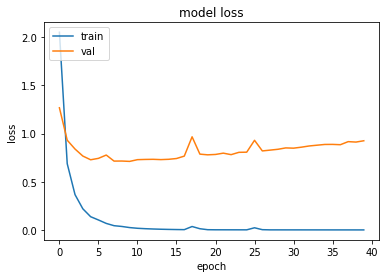

In [74]:
model1 = tf.keras.models.Sequential()
model1.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model1.add( tf.keras.layers.Dense(num_out,activation="softmax",name="cell_type") )
model1.summary()
model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
hist1=model1.fit(x=x_train,y=y_train,epochs=40,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist1)


In [77]:
make_pred_and_save_cm(model1,x_test,y_test,label_encoder.classes_,"linear_model.csv")
model1.save('model1.model')
del model1

[0.5625     0.9        0.625      0.875      0.80952381 0.85714286
 0.73684211 0.92       0.84210526 0.77777778 0.95588235 0.68181818
 0.6875     0.9        0.86666667 0.70833333 0.93975904 0.95454545
 0.66037736 0.77192982 0.69767442 0.64705882 0.35714286 0.67857143
 0.30434783 0.88235294 0.15789474 0.18181818 0.16666667 0.5
 0.8        0.7260274  0.71428571 0.15384615 0.27272727 0.83333333
 0.3125     0.66666667 0.1        0.96853933 0.88888889 0.84126984
 0.86666667 0.83333333 0.53846154 0.66666667 0.86666667 0.625
 0.82608696 0.75       0.83529412 0.74074074 0.75       0.2
 0.74285714 0.55172414 0.62857143 0.58333333 0.5        0.25
 0.         0.29166667 0.56756757 0.4375     0.2        0.25
 0.62068966 0.9047619  0.44444444 1.        ]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model1.model/assets


Add a hidden layer to make the model a bit more complex.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3253760   
_________________________________________________________________
cell_type (Dense)            (None, 70)                9030      
Total params: 3,262,790
Trainable params: 3,262,790
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
706/706 [==============================] - 18s 26ms/step - loss: 2.8496 - accuracy: 0.4400 - val_loss: 2.4165 - val_accuracy: 0.5728
Epoch 2/40
706/706 [==============================] - 19s 26ms/step - loss: 2.3139 - accuracy: 0.5777 - val_loss: 2.1795 - val_accuracy: 0.6299
Epoch 3/40
706/706 [==============================] - 18s 26ms/step - loss: 2.1663 - accuracy: 0.6225 - val_loss: 2.1618 - val_accuracy: 0.5922
Epoch 4/40
706/706 [==============================] - 18s 26ms/step - loss

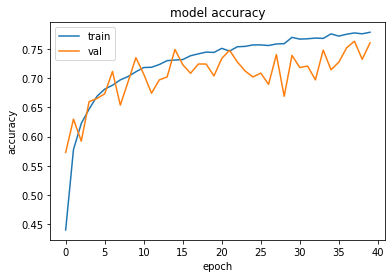

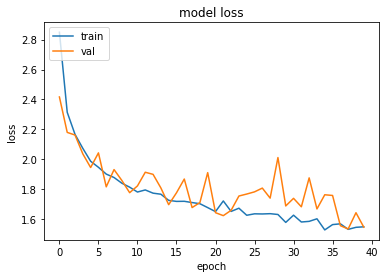

In [79]:
model2 = tf.keras.models.Sequential()
model2.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model2.add( tf.keras.layers.Dense(128,activation="relu",kernel_regularizer='l2') )
model2.add( tf.keras.layers.Dense(num_out,activation="softmax",name="cell_type") )
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
hist2=model2.fit(x=x_train,y=y_train,epochs=40,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist2)

In [81]:
make_pred_and_save_cm(model2,x_test,y_test,label_encoder.classes_,"onehidden_model.csv")
model2.save('model2.model')
del model2

[0.375      0.8        0.25       0.66666667 0.66666667 0.85714286
 0.65789474 0.68       0.84210526 0.77777778 0.82352941 0.63636364
 0.5625     0.8        0.66666667 0.70833333 0.98795181 0.86363636
 0.64150943 0.47368421 0.6744186  0.41176471 0.35714286 0.82142857
 0.17391304 0.82352941 0.05263158 0.09090909 0.66666667 0.1
 1.         0.68493151 0.67857143 0.23076923 0.36363636 0.78571429
 0.0625     0.         0.         0.95505618 0.81111111 0.87301587
 0.93333333 0.77777778 0.46153846 0.43333333 0.88888889 0.5625
 0.7826087  0.70833333 0.85882353 0.66666667 0.65       0.3
 0.77142857 0.44827586 0.82857143 0.41666667 0.625      0.41666667
 0.         0.20833333 0.2972973  0.0625     0.13333333 0.5
 0.31034483 0.71428571 0.44444444 0.4       ]
INFO:tensorflow:Assets written to: model2.model/assets


change the optimizer...

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               3253760   
_________________________________________________________________
cell_type (Dense)            (None, 70)                9030      
Total params: 3,262,790
Trainable params: 3,262,790
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
706/706 [==============================] - 15s 22ms/step - loss: 5.4919 - accuracy: 0.3185 - val_loss: 4.8679 - val_accuracy: 0.3324
Epoch 2/40
706/706 [==============================] - 16s 22ms/step - loss: 4.4566 - accuracy: 0.3581 - val_loss: 4.1129 - val_accuracy: 0.4039
Epoch 3/40
706/706 [==============================] - 15s 22ms/step - loss: 3.7916 - accuracy: 0.4379 - val_loss: 3.5484 - val_accuracy: 0.4787
Epoch 4/40
706/706 [==============================] - 16s 23ms/step - loss

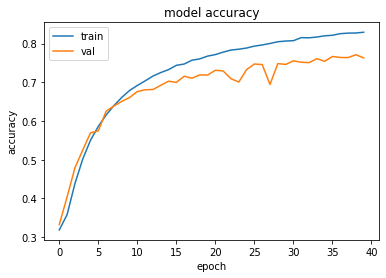

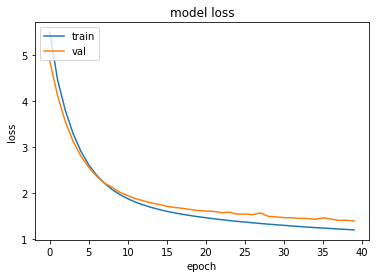

In [82]:
model2a = tf.keras.models.Sequential()
model2a.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model2a.add( tf.keras.layers.Dense(128,activation="relu",kernel_regularizer='l2') )
model2a.add( tf.keras.layers.Dense(num_out,activation="softmax",name="cell_type") )
model2a.summary()
model2a.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
hist2a=model2a.fit(x=x_train,y=y_train,epochs=40,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist2a)

In [83]:
make_pred_and_save_cm(model2a,x_test,y_test,label_encoder.classes_,"onehidden_model.csv")
model2a.save('model2a.model')
del model2a

[0.1875     0.9        0.125      0.83333333 0.76190476 0.87755102
 0.60526316 0.88       0.84210526 0.77777778 0.88235294 0.40909091
 0.5        0.9        0.86666667 0.66666667 0.91566265 0.86363636
 0.66037736 0.80701754 0.69767442 0.58823529 0.         0.57142857
 0.13043478 0.70588235 0.         0.         0.         0.2
 0.53333333 0.76712329 0.76785714 0.07692308 0.09090909 0.83333333
 0.0625     0.         0.         0.96292135 0.9        0.85714286
 0.93333333 0.72222222 0.53846154 0.53333333 0.8        0.5625
 0.73913043 0.66666667 0.90588235 0.66666667 0.7        0.1
 0.71428571 0.37931034 0.77142857 0.25       0.125      0.08333333
 0.         0.16666667 0.51351351 0.         0.         0.
 0.72413793 0.71428571 0.33333333 0.4       ]
INFO:tensorflow:Assets written to: model2a.model/assets


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cell_type (Dense)            (None, 70)                1779400   
Total params: 1,779,400
Trainable params: 1,779,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
706/706 [==============================] - 5s 7ms/step - loss: 3.2600 - accuracy: 0.3223 - val_loss: 2.9760 - val_accuracy: 0.3324
Epoch 2/40
706/706 [==============================] - 5s 7ms/step - loss: 2.8286 - accuracy: 0.3368 - val_loss: 2.7190 - val_accuracy: 0.3532
Epoch 3/40
706/706 [==============================] - 5s 8ms/step - loss: 2.5962 - accuracy: 0.3789 - val_loss: 2.5295 - val_accuracy: 0.3973
Epoch 4/40
706/706 [==============================] - 5s 8ms/step - loss: 2.4142 - accuracy: 0.4314 - val_loss: 2.3742 - val_accuracy: 0.4544
Epoch 5/40
706/706 [==============================] - 6s 8ms/step - loss

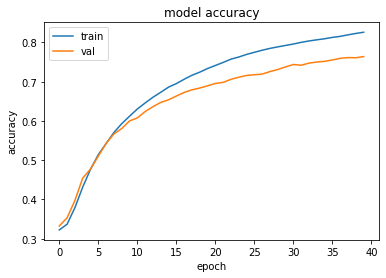

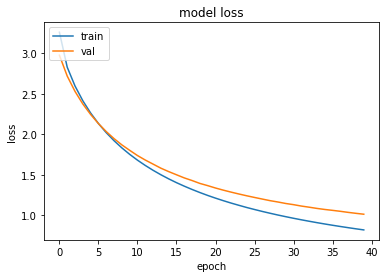

[0.1875     0.9        0.375      0.875      0.71428571 0.87755102
 0.68421053 0.92       0.78947368 0.7037037  0.92647059 0.5
 0.5        0.9        0.8        0.66666667 0.91566265 0.90909091
 0.64150943 0.68421053 0.74418605 0.52941176 0.14285714 0.53571429
 0.13043478 0.70588235 0.05263158 0.         0.         0.3
 0.73333333 0.76712329 0.80357143 0.         0.         0.83333333
 0.0625     0.         0.         0.97078652 0.87777778 0.82539683
 0.93333333 0.77777778 0.46153846 0.5        0.8        0.5625
 0.73913043 0.66666667 0.89411765 0.7037037  0.65       0.2
 0.54285714 0.4137931  0.62857143 0.5        0.25       0.
 0.         0.125      0.59459459 0.         0.         0.
 0.74137931 0.76190476 0.33333333 0.6       ]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model1a.model/assets


In [14]:
model1a = tf.keras.models.Sequential()
model1a.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model1a.add( tf.keras.layers.Dense(num_out,activation="softmax",name="cell_type") )
model1a.summary()
model1a.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
hist1a=model1a.fit(x=x_train,y=y_train,epochs=40,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist1a)
make_pred_and_save_cm(model1a,x_test,y_test,label_encoder.classes_,"linear_noreg_sgd.csv")
model1a.save('model1a.model')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cell_type (Dense)            (None, 70)                1779400   
Total params: 1,779,400
Trainable params: 1,779,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
706/706 [==============================] - 8s 12ms/step - loss: 3.4006 - accuracy: 0.3220 - val_loss: 3.1218 - val_accuracy: 0.3320
Epoch 2/50
706/706 [==============================] - 9s 12ms/step - loss: 2.9746 - accuracy: 0.3367 - val_loss: 2.8651 - val_accuracy: 0.3535
Epoch 3/50
706/706 [==============================] - 8s 12ms/step - loss: 2.7507 - accuracy: 0.3769 - val_loss: 2.6888 - val_accuracy: 0.4015
Epoch 4/50
706/706 [==============================] - 8s 12ms/step - loss: 2.5798 - accuracy: 0.4266 - val_loss: 2.5460 - val_accuracy: 0.4424
Epoch 5/50
706/706 [==============================] - 9s 12ms/step

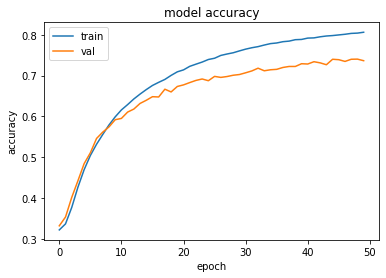

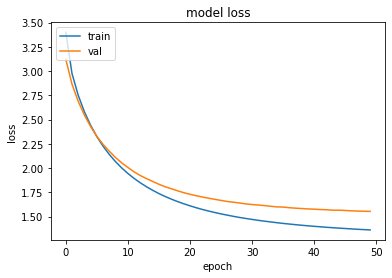

[0.1875     0.9        0.375      0.875      0.66666667 0.85714286
 0.57894737 0.92       0.76315789 0.66666667 0.91176471 0.36363636
 0.4375     0.8        0.77777778 0.66666667 0.90361446 0.95454545
 0.64150943 0.68421053 0.72093023 0.47058824 0.14285714 0.42857143
 0.08695652 0.70588235 0.         0.         0.         0.2
 0.73333333 0.7260274  0.75       0.         0.         0.83333333
 0.0625     0.         0.         0.97640449 0.85555556 0.77777778
 0.86666667 0.77777778 0.30769231 0.46666667 0.77777778 0.5625
 0.69565217 0.625      0.89411765 0.59259259 0.6        0.1
 0.45714286 0.37931034 0.51428571 0.41666667 0.125      0.
 0.         0.04166667 0.54054054 0.         0.         0.
 0.70689655 0.71428571 0.22222222 0.6       ]
INFO:tensorflow:Assets written to: model1b.model/assets


In [45]:
model1b = tf.keras.models.Sequential()
model1b.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model1b.add( tf.keras.layers.Dense(num_out,activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(0.001),name="cell_type") )
model1b.summary()
model1b.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
hist1b=model1b.fit(x=x_train,y=y_train,epochs=50,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist1b)
make_pred_and_save_cm(model1b,x_test,y_test,label_encoder.classes_,"linear_l2reg_sgd.csv")
model1b.save('model1b.model')

Epoch 1/20
706/706 [==============================] - 9s 13ms/step - loss: 1.2997 - accuracy: 0.8404 - val_loss: 1.5311 - val_accuracy: 0.7596
Epoch 2/20
706/706 [==============================] - 9s 12ms/step - loss: 1.2991 - accuracy: 0.8403 - val_loss: 1.5310 - val_accuracy: 0.7617
Epoch 3/20
706/706 [==============================] - 9s 12ms/step - loss: 1.2985 - accuracy: 0.8406 - val_loss: 1.5303 - val_accuracy: 0.7600
Epoch 4/20
706/706 [==============================] - 9s 13ms/step - loss: 1.2977 - accuracy: 0.8418 - val_loss: 1.5304 - val_accuracy: 0.7557
Epoch 5/20
706/706 [==============================] - 9s 13ms/step - loss: 1.2974 - accuracy: 0.8406 - val_loss: 1.5302 - val_accuracy: 0.7614
Epoch 6/20
706/706 [==============================] - 9s 13ms/step - loss: 1.2966 - accuracy: 0.8427 - val_loss: 1.5320 - val_accuracy: 0.7667
Epoch 7/20
706/706 [==============================] - 9s 13ms/step - loss: 1.2963 - accuracy: 0.8431 - val_loss: 1.5299 - val_accuracy: 0.7607

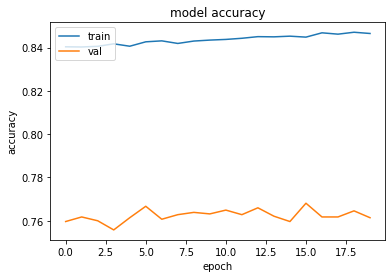

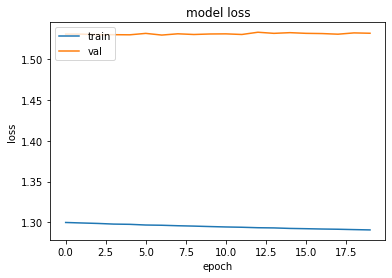

[0.1875     0.9        0.375      0.875      0.71428571 0.87755102
 0.57894737 0.92       0.76315789 0.7037037  0.91176471 0.5
 0.5        0.9        0.8        0.66666667 0.90361446 0.90909091
 0.64150943 0.68421053 0.72093023 0.52941176 0.28571429 0.57142857
 0.26086957 0.70588235 0.         0.         0.         0.3
 0.73333333 0.73972603 0.78571429 0.         0.09090909 0.83333333
 0.0625     0.         0.         0.97191011 0.85555556 0.79365079
 0.86666667 0.83333333 0.46153846 0.5        0.77777778 0.625
 0.69565217 0.66666667 0.88235294 0.66666667 0.6        0.2
 0.57142857 0.44827586 0.6        0.58333333 0.375      0.16666667
 0.         0.125      0.56756757 0.         0.         0.
 0.74137931 0.71428571 0.33333333 0.6       ]
INFO:tensorflow:Assets written to: model1b.model/assets


In [48]:
hist1b=model1b.fit(x=x_train,y=y_train,epochs=20,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist1b)
make_pred_and_save_cm(model1b,x_test,y_test,label_encoder.classes_,"linear_l2reg_sgd.csv")
model1b.save('model1b.model')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               6507520   
_________________________________________________________________
cell_type (Dense)            (None, 70)                17990     
Total params: 6,525,510
Trainable params: 6,525,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
706/706 [==============================] - 31s 43ms/step - loss: 7.6434 - accuracy: 0.3226 - val_loss: 6.7345 - val_accuracy: 0.3310
Epoch 2/80
706/706 [==============================] - 31s 44ms/step - loss: 6.0663 - accuracy: 0.3752 - val_loss: 5.4946 - val_accuracy: 0.4247
Epoch 3/80
706/706 [==============================] - 31s 44ms/step - loss: 4.9826 - accuracy: 0.4606 - val_loss: 4.5694 - val_accuracy: 0.4977
Epoch 4/80
706/706 [==============================] - 31s 44ms/step - loss

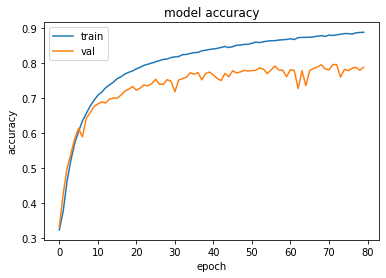

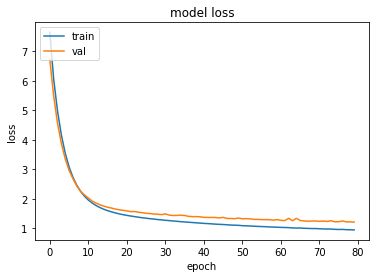

In [49]:
model2b = tf.keras.models.Sequential()
model2b.add( tf.keras.layers.Input(shape=(num_inp,),name="cell_inp") )
model2b.add( tf.keras.layers.Dense(256,activation="relu",kernel_regularizer='l2') )
model2b.add( tf.keras.layers.Dense(num_out,activation="softmax",name="cell_type") )
model2b.summary()
model2b.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
hist2b=model2b.fit(x=x_train,y=y_train,epochs=80,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist2b)

Epoch 81/100
706/706 [==============================] - 31s 43ms/step - loss: 0.9519 - accuracy: 0.8884 - val_loss: 1.2201 - val_accuracy: 0.7779
Epoch 82/100
706/706 [==============================] - 30s 43ms/step - loss: 0.9475 - accuracy: 0.8880 - val_loss: 1.2029 - val_accuracy: 0.7934
Epoch 83/100
706/706 [==============================] - 30s 43ms/step - loss: 0.9392 - accuracy: 0.8916 - val_loss: 1.2267 - val_accuracy: 0.7663
Epoch 84/100
706/706 [==============================] - 30s 43ms/step - loss: 0.9372 - accuracy: 0.8911 - val_loss: 1.2675 - val_accuracy: 0.7448
Epoch 85/100
706/706 [==============================] - 31s 44ms/step - loss: 0.9376 - accuracy: 0.8924 - val_loss: 1.2059 - val_accuracy: 0.7970
Epoch 86/100
706/706 [==============================] - 31s 44ms/step - loss: 0.9370 - accuracy: 0.8910 - val_loss: 1.2142 - val_accuracy: 0.7920
Epoch 87/100
706/706 [==============================] - 30s 43ms/step - loss: 0.9288 - accuracy: 0.8931 - val_loss: 1.1946 -

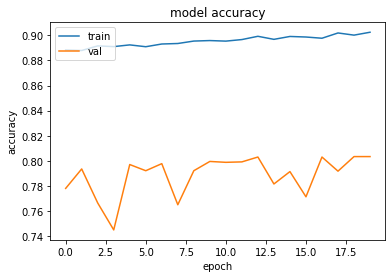

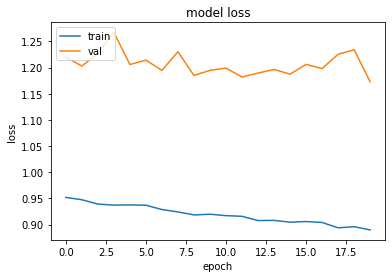

In [53]:
hist2b_1=model2b.fit(x=x_train,y=y_train,initial_epoch=80,epochs=100,batch_size=32,validation_data=(x_val,y_val))
plot_hist(hist2b_1)

In [55]:
make_pred_and_save_cm(model2b,x_test,y_test,label_encoder.classes_,"hidden_l2reg_sgd.csv")
model2b.save('model2b.model')

[0.3125     0.9        0.625      0.83333333 0.71428571 0.97959184
 0.78947368 0.88       0.86842105 0.81481481 0.94117647 0.59090909
 0.75       0.9        0.86666667 0.70833333 0.98795181 0.86363636
 0.71698113 0.75438596 0.74418605 0.82352941 0.21428571 0.71428571
 0.39130435 0.82352941 0.36842105 0.         0.         0.5
 0.8        0.73972603 0.82142857 0.38461538 0.45454545 0.85714286
 0.125      0.         0.1        0.91797753 0.91111111 0.84126984
 0.93333333 0.77777778 0.61538462 0.83333333 0.82222222 0.5625
 0.7826087  0.79166667 0.92941176 0.7037037  0.8        0.3
 0.82857143 0.65517241 0.82857143 0.75       0.5        0.25
 0.         0.29166667 0.67567568 0.1875     0.2        0.
 0.74137931 0.9047619  0.44444444 1.        ]
INFO:tensorflow:Assets written to: model2b.model/assets


In [120]:
pred = model2b.predict(x_test)
cell_class = np.argmax(pred,axis=1)
cell_type = label_encoder.inverse_transform(cell_class)
called_class = np.argmax(y_test,axis=1)
called_type = label_encoder.inverse_transform(called_class)

df = pd.DataFrame({"cell_class":cell_class,"called_class":called_class,"cell_type":cell_type,"called_type":called_type,"probability":np.max(pred,axis=1)} )
df['agree'] = df.cell_class == df.called_class
df

,cell_class,called_class,cell_type,called_type,probability,agree
0,39,39,Garbage,Garbage,0.947911,True
1,39,39,Garbage,Garbage,0.964306,True
2,39,39,Garbage,Garbage,0.097964,True
3,39,39,Garbage,Garbage,0.957435,True
4,1,1,Excit-01,Excit-01,0.538859,True
...,...,...,...,...,...,...
2805,35,35,Excit-35,Excit-35,0.972334,True
2806,62,62,Inhib-23,Inhib-23,0.951047,True
2807,22,22,Excit-22,Excit-22,0.453575,True
2808,35,39,Excit-35,Garbage,0.799530,False


In [92]:
print(df[df.agree==True].shape[0]/df.shape[0])

0.800355871886121

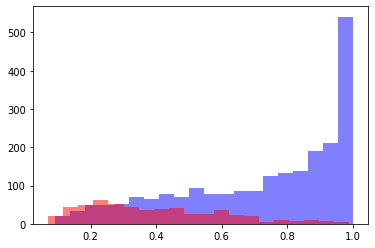

In [101]:
plt.hist(df.probability[df.agree==True], 20,fc=(0, 0, 1, 0.5))
plt.hist(df.probability[df.agree==False],20,fc=(1, 0, 0, 0.5))

df.to_csv("test_hidden_l2_sgd_labels.csv")

In [159]:

called = pd.DataFrame({"cell_call":ohe_encoder.inverse_transform(y_test)})
c_class=pd.DataFrame( pred.argsort(axis=1)[:,-1:-6:-1], columns=["class1","class2","class3","class4","class5"] )
probs = pd.DataFrame( np.sort(pred,axis=1)[:,-1:-6:-1], columns=["p1","p2","p3","p4","p5"] )
c_type = c_class.apply(label_encoder.inverse_transform)
mix = pd.concat([called,c_type,probs],axis=1)
mix["agree"]=mix.cell_call==mix.class1
mix = mix[ ["cell_call","class1","p1","class2","p2","class3","p3","class4","p4","class5","p5","agree"] ]

display(mix[mix.agree==True])
display(mix[mix.agree==False])


,cell_call,class1,p1,class2,p2,class3,p3,class4,p4,class5,p5,agree
0,Garbage,Garbage,0.947911,Excit-06,0.003549,Excit-19,0.002881,Excit-04,0.002599,Excit-18,0.002405,True
1,Garbage,Garbage,0.964306,Inhib-01,0.001864,Inhib-06,0.001789,Inhib-15,0.001602,Inhib-02,0.001441,True
2,Garbage,Garbage,0.097964,Excit-36,0.066826,Excit-23,0.050085,Excit-12,0.050055,Excit-31,0.049984,True
3,Garbage,Garbage,0.957435,Inhib-01,0.005529,Inhib-06,0.002902,Excit-06,0.002186,Inhib-02,0.002004,True
4,Excit-01,Excit-01,0.538859,Excit-02,0.181999,Excit-08,0.039643,Excit-06,0.028349,Excit-03,0.026483,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2804,Inhib-09,Inhib-09,0.748756,Inhib-10,0.204457,Inhib-11,0.014717,Inhib-13,0.004161,Inhib-06,0.003845,True
2805,Excit-35,Excit-35,0.972334,Excit-33,0.007899,Inhib-24,0.004996,Excit-28,0.001795,Excit-22,0.001727,True
2806,Inhib-23,Inhib-23,0.951047,Excit-35,0.039657,Excit-31,0.002978,Inhib-22,0.002666,MN-alpha,0.001301,True
2807,Excit-22,Excit-22,0.453575,Excit-35,0.134517,Excit-21,0.101361,Excit-12,0.092357,Excit-33,0.030996,True


,cell_call,class1,p1,class2,p2,class3,p3,class4,p4,class5,p5,agree
5,Garbage,Excit-05,0.197092,Excit-04,0.180766,Garbage,0.159478,Excit-06,0.099084,Excit-03,0.058497,False
8,Inhib-16,Inhib-23,0.267175,Garbage,0.156823,Inhib-16,0.149930,Inhib-17,0.130880,Inhib-01,0.066123,False
9,Garbage,Excit-29,0.127950,Inhib-24,0.098418,Inhib-22,0.069079,Inhib-20,0.052727,Excit-38,0.045292,False
13,Inhib-16,Inhib-02,0.208540,Inhib-16,0.081105,Inhib-18,0.051618,Inhib-12,0.045930,Inhib-01,0.041877,False
18,Excit-32,Garbage,0.389286,Excit-36,0.048347,Excit-33,0.039080,Excit-22,0.038466,Excit-29,0.032079,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2797,Excit-21,Excit-35,0.291996,Excit-21,0.273889,Excit-22,0.231818,Excit-29,0.059498,Excit-34,0.025228,False
2798,Excit-33,Excit-35,0.469433,Excit-22,0.080424,Excit-21,0.079644,Excit-29,0.078963,Inhib-24,0.066958,False
2799,Excit-33,Excit-35,0.830901,Excit-33,0.139807,Excit-22,0.004550,Excit-29,0.003881,Excit-31,0.003626,False
2802,Excit-19,Excit-06,0.442177,Excit-19,0.433384,Excit-13,0.018609,Excit-35,0.017950,Excit-01,0.011880,False
